In [1]:
# import needed libraries
import pandas as pd
import helper.Utils as Utils
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import pandas as pd
import pyterrier as pt
from mono_bert_train import MonoBertTrainer
from mono_bert_test import MonoBertTester
import configure  as cf
from train_set_creator import MonoBertTrainSetCreator
from pyterrier.measures import RR, R, Rprec, P, MAP

2022-07-29 12:14:51.211540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 12:14:51.211583: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

if not pt.started():
    print("Enabling PRF in pyterier")
    # In this lab, we need to specify that we start PyTerrier with PRF enabled
    pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

Enabling PRF in pyterier
PyTerrier 0.6.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:

# define some constants.
DECIMAL_ROUND = 5
RANK = cf.RANK
SCORE = cf.SCORE
TWEET_ID_COLUMN = cf.TWEET_ID_COLUMN
TWEET_TEXT_COLUMN = cf.TWEET_TEXT_COLUMN
VCLAIM_ID = cf.VCLAIM_ID
VCLAIM = cf.VCLAIM
TITLE = cf.TITLE 
LABEL = cf.LABEL
QUERY = cf.QUERY
QID = cf.QID

claims_file = cf.ENG_CLEF_2020_VCLAIMS
index_path = "./indexes/en-clef-2020-index-multi-field/data.properties"
evaluation_save_path = "./data/clef-2020-mono-bert-evaluations.xlsx"

train_query_path=cf.ENG_CLEF_2020_URL_CLEANED_TRAIN_QUERIES
raw_dev_query = cf.ENG_CLEF_2020_DEV_QUERIES
expanded_dev_query = cf.ENG_CLEF_2020_URL_CLEANED_DEV_QUERIES
dev_query_path = expanded_dev_query
test_query_path =cf.ENG_CLEF_2020_URL_CLEANED_TEST_QUERIES
qrels_file=cf.ENG_CLEF_2020_QRELS

eval_metrics=["map",MAP@5, P@1, RR, Rprec, R@5, R@10, R@20, R@50, RR@5]

NUM_CLASSES = 2
ONE_LAYER = 1
TWO_LAYERS = 2
NUM_OF_EXTRA_NEGATIVE_EXAMPLES = 1


dev_bm25_run = "./data/runs/bm25_dev_query_en_clef_2020.tsv"
train_bm25_run = "./data/runs/bm25_train_query_en_clef_2020.tsv"
mono_bert_train_set = "./data/CLEF_2020/train_sets/mono_bert_train_set-depth-20.xlsx"
mono_bert_dev_set_depth_20 ="./data/CLEF_2020/dev_sets/en-clef2020-mono_bert_dev_set_top_20.tsv"
SEARCH_DEPTH = 100
RANDOM_DEPTH = 20 # depth from which negative pairs will be randomly selected from top k documents retrieved from a retrieval model


random_seeds = [61168821, 129995678, 22612812, 146764631, 21228945, 94412880, 204110176, 6155814, 187372311, 117623077,]



In [4]:
# Read verified claims file
df_claim = Utils.read_file(claims_file)
df_claim[VCLAIM_ID]= df_claim[VCLAIM_ID].astype(str)
df_claim.set_index(VCLAIM_ID, inplace=True)
df_claim

,vclaim,title
vclaim_id,,
0,122 detainees released from confinement at Gua...,Did 122 Prisoners Released from Guantanamo by ...
1,70 per cent of the persons arrested during pro...,70% of Arrested Charlotte Protesters Are Out-o...
2,"A ""Trump and Obama by the Numbers"" meme recoun...",Does This Meme Accurately Show ‘Trump and Obam...
3,"A ""large-scale killing"" of white farmers is ta...",Is a ‘Large-Scale Killing’ of White Farmers Un...
4,"A ""law to separate families"" was enacted prior...",Was the ‘Law to Separate Families’ Passed in 1...
...,...,...
10370,"“Slime,” a do-it-yourself gooey craft project ...",Does the “Slime” Craze Bring Serious Health Ri...
10371,“Sun tea” (tea brewed by being left to steep i...,Bacteria in Sun Tea Risk
10372,"“The Real Deal,” words of wisdom about gas, ge...",Red Thomas ‘Real Deal’ Letter


## Create multi-fields index

In [5]:
def load_index(index_path):
    try:
            # first load the index
        multi_field_index = pt.IndexFactory.of(index_path)
        # call getCollectionStatistics() to check the stats
        print(multi_field_index.getCollectionStatistics().toString())
        print("Index has been loaded successfully")
        return multi_field_index
    except Exception as e:
        print('Cannot load the index, check exception details {}'.format(e))
        return []


multi_field_index = load_index(index_path=index_path)

Number of documents: 10375
Number of terms: 13271
Number of postings: 118516
Number of fields: 2
Number of tokens: 162893
Field names: [text, title]
Positions:   false

Index has been loaded successfully


## Load QRELs file

In [6]:
def get_qrels(qrels_file):
    df_qrels = pd.read_csv(qrels_file, sep="\t", names=["qid", "Q0", "docno", LABEL])
    df_qrels["qid"]=df_qrels["qid"].astype(str)
    df_qrels["docno"]=df_qrels["docno"].astype(str)
    return df_qrels

df_qrels = get_qrels(qrels_file)
df_qrels

,qid,Q0,docno,label
0,1,0,394,1
1,2,0,670,1
2,3,0,670,1
3,4,0,141,1
4,5,0,83,1
...,...,...,...,...
1193,1193,0,579,1
1194,1194,0,9588,1
1195,1195,0,5455,1
1196,1196,0,5338,1


Helpful functions for creating the train, dev and test sets in monoBERT fashion

In [7]:
def create_train_set(mono_train_set_creator, train_query_path, train_bm25_run_path, bm25_evaluation_save_path,train_set_save_path, 
                    search_depth=100, query_column="cleaned", retrieval_model="BM25", depth_of_random=20,
                    what_to_add=cf.VCLAIM_AND_TITLE,  add_similarity=False, lang="en"):


   # 1- create run for both dev and train queries
    print("Make runs and evaluation")
    mono_train_set_creator.search_and_evaluate(query_path=train_query_path, evaluation_path=bm25_evaluation_save_path, 
                        retrieval_model=retrieval_model, run_save_path=train_bm25_run_path, 
                        depth=search_depth, method_name="bm25_train+dev", data_column=query_column, lang=lang)
    print("Done with runs and evaluation")

    # 2- create the training set
    print("Creating train set")
    mono_train_set_creator.create_train_pairs(train_query_path, train_bm25_run_path, train_set_save_path, 
                            query_column="cleaned", what_to_add=what_to_add, 
                            depth_of_random=depth_of_random, add_similarity=add_similarity,)
    print("Done creating train set")



# create test set suitable for mono BERT re-ranker
def create_test_set(mono_train_set_creator, query_path, run_path, bm25_evaluation_save_path, pairs_save_path, 
                    search_depth=100, query_column="cleaned", retrieval_model="BM25", lang="en"):


   # 1- create run for both dev and train queries
    print("Make runs and evaluation for depth ", search_depth)
    mono_train_set_creator.search_and_evaluate(query_path=query_path, evaluation_path=bm25_evaluation_save_path, 
                        retrieval_model=retrieval_model, run_save_path=run_path, 
                        depth=search_depth, method_name="bm25_dev-or-test", data_column=query_column, lang=lang)
    print("Done with runs and evaluation")

    # 2- create the training set
    print("Creating test/dev set for mono BERT from queries path: ", query_path)
    mono_train_set_creator.create_test_pairs(query_path, run_path, query_column="cleaned", 
                    pairs_save_path=pairs_save_path,)
    print("Done creating test set for mono BERT")
    
    return  


## Create training data for mono BERT

In [8]:
mono_train_set_creator = MonoBertTrainSetCreator(qrels_file, claims_file, index_path, eval_metrics)
mono_bert_trainer = MonoBertTrainer(train_query_path, dev_query_path, qrels_path=qrels_file,)
mono_bert_tester = MonoBertTester(qrels_path=qrels_file, evaluation_save_path=evaluation_save_path)

Number of documents: 10375
Number of terms: 13271
Number of postings: 118516
Number of fields: 2
Number of tokens: 162893
Field names: [text, title]
Positions:   false

Index has been loaded successfully


In [9]:

df_train_set_both = create_train_set(mono_train_set_creator, train_query_path, train_bm25_run, "",
                    train_set_save_path=mono_bert_train_set, 
                    search_depth=SEARCH_DEPTH, query_column="cleaned", retrieval_model="BM25", depth_of_random=RANDOM_DEPTH,
                    what_to_add=cf.VCLAIM_AND_TITLE, add_similarity=False,)



Make runs and evaluation
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating train set
Processing tweet number 0 with tweet id 1 
Processing tweet number 100 with tweet id 125 
Processing tweet number 200 with tweet id 245 
Processing tweet number 300 with tweet id 367 
Processing tweet number 400 with tweet id 497 
Processing tweet number 500 with tweet id 615 
Processing tweet number 600 with tweet id 748 
Processing tweet number 700 with tweet id 881 
Done creating train set


## Create dev sets from top k retrieved documents by bm25

In [11]:

depths = [10, 20, 30, 50, 100,]
for i in range(len(depths)):
    depth = depths[i]
    bm25_run_path =  "./data/runs/bm25_dev_query_en_clef_2020_depth_" + str(depth) + ".tsv"
    mono_bert_dev_set = "./data/CLEF_2020/dev_sets/en-clef2020-mono_bert_dev_set_top_" + str(depth) + ".tsv"

    create_test_set(mono_train_set_creator, dev_query_path, bm25_run_path, 
                    bm25_evaluation_save_path="", pairs_save_path=mono_bert_dev_set, 
                    search_depth=depth, query_column="cleaned", retrieval_model="BM25", lang="en")






Make runs and evaluation for depth  10
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2020/url_cleaned_dev_queries.xlsx
1000  rows have been created so far 
Done creating test set for mono BERT
Make runs and evaluation for depth  20
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2020/url_cleaned_dev_queries.xlsx
1000  rows have been created so far 
2000  rows have been created so far 
3000  rows have been created so far 
Done creating test set for mono BERT
Make runs and evaluation for depth  30
C

------------------------------------------------------------------------------------
## Create test sets from top k documents retrieved by bm25
------------------------------------------------------------------------------------

In [12]:
depths = [10, 20, 30, 50, 100,]

for i in range(len(depths)):
    depth = depths[i]
    bm25_run_path =  "./data/runs/bm25_test_query_en_clef_2020_depth_" + str(depth) + ".tsv"
    mono_bert_test_set_path = "./data/CLEF_2020/test_sets/mono_bert_test_set_top_" + str(depth) + ".tsv"

    
    create_test_set(mono_train_set_creator, test_query_path, bm25_run_path, 
                    bm25_evaluation_save_path="", pairs_save_path=mono_bert_test_set_path, 
                    search_depth=depth, query_column="cleaned", retrieval_model="BM25", lang="en")



                   

Make runs and evaluation for depth  10
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2020/url_cleaned_test_queries.xlsx
1000  rows have been created so far 
Done creating test set for mono BERT
Make runs and evaluation for depth  20
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2020/url_cleaned_test_queries.xlsx
1000  rows have been created so far 
2000  rows have been created so far 
3000  rows have been created so far 
Done creating test set for mono BERT
Make runs and evaluation for depth  30

Get the maximum length needed to tokenize a pair of query and document in the training set

Maximum length of a tokenized example is :  222
Sentence Lengths: 


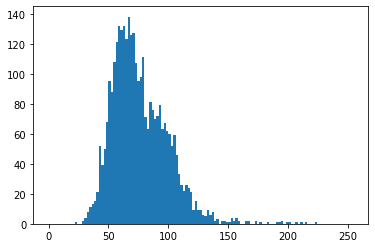

Number of documents that are bigger than max legnth 
0


In [15]:
# measure the maximum length needed to tokenize a triplet
def get_pairs_max_length(data_path, tokenizer, max_length):
    df = Utils.read_file(data_path)
    lengths = []
    maxl = 0
    for i, row in df.iterrows():
        query = row[TWEET_TEXT_COLUMN]
        document = row[VCLAIM]
        row_len = len(tokenizer.tokenize(query)) +len(tokenizer.tokenize(document))
        lengths.append(row_len)
        maxl = max(maxl, row_len)
    print("Maximum length of a tokenized example is : ", maxl)
    print("Sentence Lengths: ")
    plt.hist(lengths ,bins=range(0,256,2))
    plt.show()

    print("Number of documents that are bigger than max legnth ")
    print(sum([length > max_length for length in lengths]))
    
    return 

BERT = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(BERT)
get_pairs_max_length(mono_bert_train_set ,tokenizer, max_length=256)

## Tuning the model on dev set to figure out the best depth of the initial retrieved list

In [10]:
depth_evaluation_file = "./data/evaluation/en-clef-2020-mono-bert-depth-evaluation-on-dev-set.xlsx"
bert_models = [
            "sentence-transformers/paraphrase-mpnet-base-v2",
            "sentence-transformers/stsb-mpnet-base-v2",
            "sentence-transformers/msmarco-roberta-base-v2",
            "sentence-transformers/paraphrase-MiniLM-L12-v2",
            ]
models_names = [
            "paraphrase-mpnet-base-v2",
            "stsb-mpnet-base-v2",
            "msmarco-roberta-base-v2",
            "paraphrase-MiniLM-L12-v2",
            ]



num_rand_seeds  = 5
seeds = random_seeds[:num_rand_seeds]
for i in range(len(bert_models)):
    l = 0
    seed = seeds[l]
    bert_model = bert_models[i]
    model_name = models_names[i]
    print("---------- training for model : --------", model_name)
    hp = { # hyper parameters
    "model_name": bert_model,
    "name": model_name +"-seed-"+ str(seed),
    "model_save_path": "./data/saved_models/EN-clef2020-"+model_name+"_mono_trained_model-seed-"+ str(seed)+".bin",
    "model_training_log": "./data/bert_evaluation/en-clef2020-mono_"+model_name+"_training_log-seed-"+ str(seed)+".xlsx",
    "batch_size": 32,
    "num_of_epochs": [4], 
    "learning_rate" : [2e-5,],
    "dropout": [0.3,], 
    "seeds": [seed],
    "max_len": 256,
    "curricula_type": 0,
    "end_of_curriculum": [0],
    "num_of_layers": ONE_LAYER,
    "is_output_probability": False, # if false, put loss_function = mono_loss, otherwise put loss_function=CrossEntropy
    "loss_function": "mono_loss"}
   

    _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                        mono_bert_train_set, mono_bert_dev_set_depth_20, hp["model_name"], apply_cleaning=False,  seeds=hp["seeds"],
                        trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                        batch_size=hp["batch_size"],epochs=hp["num_of_epochs"], learning_rates = hp["learning_rate"],
                        is_output_probability=hp["is_output_probability"],  end_of_curriculums=hp["end_of_curriculum"],
                        curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                        classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)


    # store the best hyperparameters
    hp["num_of_epochs"]= best_num_of_epochs
    hp["learning_rate"]= best_learning_rate
    hp["end_of_curriculum"]= best_end_of_curriculum
    hp["dropout"]= best_dropout


   
    depths = [10, 20, 30, 50, 100]
    for i in range(len(depths)):
        depth = depths[i]
        mono_bert_dev_set = "./data/CLEF_2020/dev_sets/en-clef2020-mono_bert_dev_set_top_"+ str(depth) + ".tsv"
        hp["test_depth"] = depth
        run_name = "en-clef2020-mono_"+model_name+"-seed-"+str(seed)+"_rerankded_data-dev-set_of_depth_" +str(depth)+".tsv"
        hp["reranked_data_path"] = "./data/runs/" + run_name
        hp["trec_run_path"] = "./data/runs/trec_eval/EN2020/"+ run_name

        mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_dev_set, 
                                hp["reranked_data_path"],  depth_evaluation_file, max_len=hp["max_len"], batch_size=hp["batch_size"],
                                dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                                hyper_parameters=hp,  classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                                what_to_test=cf.VCLAIM_AND_TITLE)
        

---------- training for model : -------- paraphrase-mpnet-base-v2
device:  cuda:0
train size  3204
dev size  3940
Epoch 1/4
----------
  Batch    40  of    101.    Elapsed: 0:00:32.
  Batch    80  of    101.    Elapsed: 0:01:03.

  correct_predictions: 2535.00
  Accuracy : 0.79
  Average training loss: 0.45
relevance results F1 score  0.7767767767767768  precision 0.8344086021505376 recall 0.7265917602996255
 Macro F1 0.7903233048351781 Weighted F1 0.7903233048351781 Accuracy 0.7911985018726592
Train loss 0.4467813774279439 accuracy 0.7911985018726592
Running Evaluation...
  Batch   100  of    124.    Elapsed: 0:00:28.
Done with re-ranking tweets 
Output is saved into  
Trec run is saved into  ./data/runs/dev_resuable_trec_run.tsv
 
 Done evaluation  -------------------
  Map measure : 0.81
  Accuracy: 0.93
  Average Validation loss: 0.23 

Dev loss 0.23071459707834066 accuracy 0.9286802030456853 eval_measures {'map': 0.8079751276227837, 'AP@5': 0.8058375634517766, 'P@1': 0.73604060913

## Training and testing multiple bert  models

In [11]:
bert_models = [
            "sentence-transformers/paraphrase-mpnet-base-v2",
            "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
            "sentence-transformers/stsb-mpnet-base-v2",
            "sentence-transformers/msmarco-roberta-base-v2",
            "sentence-transformers/paraphrase-MiniLM-L12-v2",
            "bert-base-cased",
            ]
models_names = [
            "paraphrase-mpnet-base-v2",
            "paraphrase-multilingual-mpnet-base-v2",
            "stsb-mpnet-base-v2",
            "msmarco-roberta-base-v2",
            "paraphrase-MiniLM-L12-v2",
            "BERT",
            ]
            
num_rand_seeds  = 5
seeds = random_seeds[:num_rand_seeds]
for i in range(len(bert_models)):
    l = 0
    seed = seeds[l]
    bert_model = bert_models[i]
    model_name = models_names[i]
    print("---------- training for model : --------", model_name)
    hp = { # hyper parameters

    "model_name": bert_model,
    "name": model_name +"-seed-"+ str(seed),
    "model_save_path": "./data/saved_models/EN-clef2020-"+model_name+"_mono_trained_model-tuning-seed-"+ str(seed)+".bin",
    "model_training_log": "./data/bert_evaluation/en-clef2020-mono_"+model_name+"_training_log-tuning-seed-"+ str(seed)+".xlsx",
    "batch_size": 32,
    "test_depth": 30,
    "num_of_epochs": [3, 4, 5], 
    "learning_rate" : [2e-5, 3e-5],
    "dropout": [0.3, 0.4,], 
    "seeds": [seed],
    "max_len": 256,
    "curricula_type": 0,
    "end_of_curriculum": [0],
    "num_of_layers": ONE_LAYER,
    "is_output_probability": False, # if false, put loss_function = mono_loss, otherwise put loss_function=CrossEntropy
    "loss_function": "mono_loss"}
   


    _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                        mono_bert_train_set, mono_bert_dev_set_depth_20, hp["model_name"], apply_cleaning=False,  seeds=hp["seeds"],
                        trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                        batch_size=hp["batch_size"],epochs=hp["num_of_epochs"], learning_rates = hp["learning_rate"],
                        is_output_probability=hp["is_output_probability"],  end_of_curriculums=hp["end_of_curriculum"],
                        curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                        classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)


    # store the best hyperparameters
    hp["num_of_epochs"]= best_num_of_epochs
    hp["learning_rate"]= best_learning_rate
    hp["end_of_curriculum"]= best_end_of_curriculum
    hp["dropout"]= best_dropout


    # measure the performance on the test set
    depths = [20,]
    for k in range(len(depths)):
        depth = depths[k]
        hp["test_depth"] = depth
        mono_bert_test_set_path = "./data/CLEF_2020/test_sets/mono_bert_test_set_top_" + str(depth) + ".tsv"
        run_name = "en-clef2020-mono_"+model_name+"-seed-"+str(seed)+"_rerankded_data-depth_" +str(depth)+".tsv"
        hp["reranked_data_path"] = "./data/runs/" + run_name
        hp["trec_run_path"] = "./data/runs/trec_eval/EN2020/"+ run_name

        mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_test_set_path, 
                        hp["reranked_data_path"],  evaluation_save_path, max_len=hp["max_len"], batch_size=hp["batch_size"],
                        dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                        hyper_parameters=hp, classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                        what_to_test=cf.VCLAIM_AND_TITLE)


    # then we get the best hyper parameters values
    # and we can run the training with different random seeds

    l = 1
    while l < num_rand_seeds:
        seed = seeds[l]
        l = l + 1
        hp["name"] = model_name +"-seed-"+ str(seed)
        hp["model_save_path"]= "./data/saved_models/EN-clef2020-"+model_name+"_mono_trained_model-tuning-seed-"+ str(seed)+".bin"
        hp["model_training_log"]= "./data/bert_evaluation/en-clef2020-mono_"+model_name+"_training_log-tuning-seed-"+ str(seed)+".xlsx"
        hp["learning_rate"]= [best_learning_rate]
        hp["num_of_epochs"]= [best_num_of_epochs]
        hp["end_of_curriculum"]= [best_end_of_curriculum]
        hp["dropout"]= [best_dropout]
        hp["seeds"] = [seed]


        _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                        mono_bert_train_set, mono_bert_dev_set_depth_20, hp["model_name"], apply_cleaning=False,  seeds=hp["seeds"],
                        trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                        batch_size=hp["batch_size"],epochs=hp["num_of_epochs"], learning_rates = hp["learning_rate"],
                        is_output_probability=hp["is_output_probability"],  end_of_curriculums=hp["end_of_curriculum"],
                        curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                        classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)

        # store the best hyperparameters
        hp["num_of_epochs"]= best_num_of_epochs
        hp["learning_rate"]= best_learning_rate
        hp["end_of_curriculum"]= best_end_of_curriculum
        hp["dropout"]= best_dropout


         # measure the performance on the test set
        depths = [20,]
        for k in range(len(depths)):
            depth = depths[k]
            hp["test_depth"] = depth
            mono_bert_test_set_path = "./data/CLEF_2020/test_sets/mono_bert_test_set_top_" + str(depth) + ".tsv"
            run_name = "en-clef2020-mono_"+model_name+"-seed-"+str(seed)+"_rerankded_data-depth_" +str(depth)+".tsv"
            hp["reranked_data_path"] = "./data/runs/" + run_name
            hp["trec_run_path"] = "./data/runs/trec_eval/EN2020/"+ run_name

            mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_test_set_path, 
                            hp["reranked_data_path"],  evaluation_save_path, max_len=hp["max_len"], batch_size=hp["batch_size"],
                            dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                            hyper_parameters=hp, classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                            what_to_test=cf.VCLAIM_AND_TITLE)



---------- training for model : -------- paraphrase-mpnet-base-v2
device:  cuda:0
train size  3204
dev size  3940
Epoch 1/3
----------
  Batch    40  of    101.    Elapsed: 0:00:32.
  Batch    80  of    101.    Elapsed: 0:01:04.

  correct_predictions: 2570.00
  Accuracy : 0.80
  Average training loss: 0.41
relevance results F1 score  0.788101604278075  precision 0.8482014388489209 recall 0.7359550561797753
 Macro F1 0.8012522072912622 Weighted F1 0.8012522072912623 Accuracy 0.8021223470661673
Train loss 0.41303354702742384 accuracy 0.8021223470661673
Running Evaluation...
